# Flat Unrolled Cascade - Multi-channel - Train

- Multi-channel data
- Images are 218x170
- R=4.5 

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import os
import glob
import sys
from scipy.io import loadmat
# Importing our model
MY_UTILS_PATH = "../Modules/"
if not MY_UTILS_PATH in sys.path:
    sys.path.append(MY_UTILS_PATH)
import cs_models_mc as fsnet

# Importing callbacks and data augmentation utils
from keras.callbacks import ModelCheckpoint, EarlyStopping
from data_generator import DataGenerator
from keras.optimizers import  Adam

Using TensorFlow backend.


(100, 218, 170)
Undersampling: 0.8013043712898004
Mask type: bool
(100, 218, 170)


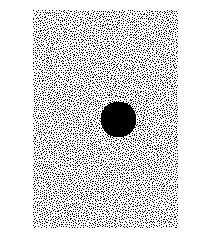

In [2]:
## PARAMETERS
H,W = 218,170 # Training image dimensions
channels = 24 # complex data 0-> real; 1-> imaginary
norm = np.sqrt(H*W)
batch_size = 5
# undersampling patterns - centered k-space - 100 pre computed patterns
var_sampling_mask = ~np.load("../Data/Sampling-patterns/218x170/poisson_center_radius=18_20perc.npy")
print(var_sampling_mask.shape)

print("Undersampling:", 1.0*var_sampling_mask.sum()/var_sampling_mask.size)
print("Mask type:",  var_sampling_mask.dtype)
print(var_sampling_mask.shape)
plt.figure()
plt.imshow(var_sampling_mask[0],cmap = "gray")
plt.axis("off")
plt.show()

In [3]:
# Train Set 
train_path = "/home/ubuntu/volume1/Slices/Train-mc/*.npy"
kspace_files_train = np.asarray(glob.glob(train_path))
indexes = np.arange(kspace_files_train.shape[0],dtype = int)
np.random.shuffle(indexes)
kspace_files_train = kspace_files_train[indexes]

# Validation set
val_path = "/home/ubuntu/volume1/Slices/Val-mc/*.npy"
kspace_files_val = np.asarray(glob.glob(val_path))
indexes = np.arange(kspace_files_val.shape[0],dtype = int)
np.random.shuffle(indexes)
kspace_files_val = kspace_files_val[indexes]

print(kspace_files_train[-1])
print(len(kspace_files_train))

print(kspace_files_val[-1])
print(len(kspace_files_val))

var_sampling_mask = var_sampling_mask[:,:,:,np.newaxis]
var_sampling_mask = np.tile(var_sampling_mask,(1,1,1,24))
print(var_sampling_mask.shape)
train_generator = DataGenerator(kspace_files_train,var_sampling_mask,norm,batch_size=8)
val_generator = DataGenerator(kspace_files_val,var_sampling_mask,norm,batch_size=8)

/home/ubuntu/volume1/Slices/Train-mc/e14498s5_P60928.7_image_slice138.jpg.npy
10240
/home/ubuntu/volume1/Slices/Val-mc/e14258s3_P76800.7_image_slice103.jpg.npy
2560
(100, 218, 170, 24)


(8, 218, 170, 24)


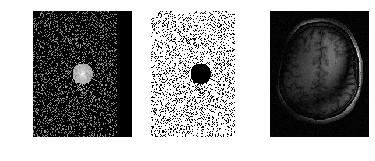

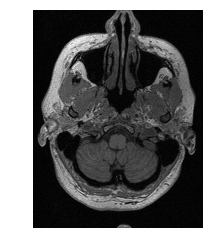

In [4]:
ii  = train_generator.__getitem__(2)
plt.figure()
plt.subplot(131)
plt.imshow(np.log(1+np.abs((ii[0][0][5,:,:,0]+1j*ii[0][0][5,:,:,1]))),cmap = "gray")
plt.axis("off")
plt.subplot(132)
plt.imshow(ii[0][1][5,:,:,0],cmap = "gray")
plt.axis("off")
plt.subplot(133)
print(ii[1].shape)
plt.imshow(np.abs(ii[1][7,:,:,5]+1j*ii[1][7,:,:,6]),cmap = "gray")
plt.axis("off")
plt.show()
sum_of_squares = (ii[1][4,:,:,::2]+1j*ii[1][4,:,:,1::2])
sum_of_squares = ((np.abs(sum_of_squares))**2).sum(axis = -1)/12
sum_of_squares = np.sqrt(sum_of_squares)
plt.figure()
plt.imshow(sum_of_squares,cmap = "gray")
plt.axis("off")
plt.show()

## Model Parameters

In [5]:
epochs = 30
batch_size= 8
earlyStopping = EarlyStopping(monitor='val_loss',
                                           patience=5, 
                                           verbose=0, mode='min')

In [ ]:
model_name = "../Models/flat_unrolled_cascade_ikikii_mc.hdf5"
print(model_name)
    
# Checkpoint callback to save model  along the epochs
checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                             monitor='val_loss',verbose=0,\
                             save_best_only=True, save_weights_only = True)

model = fsnet.deep_cascade_flat_unrolled(depth_str="ikikii",H=218, W=170)
opt = Adam(lr = 1e-3)
model.compile(loss = fsnet.nrmse_min_max,optimizer=opt)

hist = model.fit_generator(train_generator,
                               epochs=epochs,
                               steps_per_epoch=kspace_files_train.size//batch_size,
                               verbose=1,
                               validation_data= val_generator,
                               callbacks=[checkpoint,earlyStopping])

../Models/flat_unrolled_cascade_ikikii_mc.hdf5
Instructions for updating:
Colocations handled automatically by placer.


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Instructions for updating:
Use tf.cast instead.
Epoch 1/30
  98/1280 [=>............................] - ETA: 33:31 - loss: 0.3769